
This workshop aims at generating Land Surface Temperature (LST) and other relevant products (NDVI,Surface Emissivity, and  Fractional vegetation cover) 
for assessing urban climates (urban heat islands) from Landsat 8 imagery using open python geospatial tools.

In this workshop we will go through the workflow using the single channel approach by Jiménez-Muñoz et. al. 2009. 

We will end by assesing the tempertures and population distribution within the city of Tallinn. 

This will give planners and policy makers an idea where people are affected by heatwaves the highest within the city. 




Some resources:
    
How to download data: https://lta.cr.usgs.gov/sites/default/files/LS_C2_Help_122020.pd

Sobrino, J.A.; Jimenez-Muoz, J.C.; Soria, G.; Romaguera, M.; Guanter, L.; Moreno, J.;
Plaza, A.; Martinez, P., "Land Surface Emissivity Retrieval From Different VNIR and TIR Sensors," in Geoscience and Remote Sensing, IEEE Transactions on , vol.46, no.2, pp.316-
327, Feb. 2008 doi: 10.1109/TGRS.2007.904834
    
J. C. Jimenez-Munoz, J. Cristobal, J. A. Sobrino, G. Soria, M. Ninyerola and X. Pons, 
"Revision of the Single-Channel Algorithm for Land Surface Temperature Retrieval From Landsat Thermal-Infrared Data," 
in IEEE Transactions on Geoscience and Remote Sensing, vol. 47, no. 1, pp. 339-349, Jan. 2009, doi: 10.1109/TGRS.2008.2007125.
        


Data: Landsat 8 image on 18.07.2020

In [1]:
#import the needed packages

import os 
import glob

import numpy as np
import pandas as pd

import rasterio as rio
from rasterio.crs import CRS


import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from geocube.api.core import make_geocube
from rasterstats import zonal_stats
from affine import Affine



import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import libpysal as lp
from splot.mapping import vba_choropleth, mapclassify_bin, vba_legend
import warnings
warnings.filterwarnings('ignore')

In [2]:
#define Image folder path and necessary bands



grids = gpd.read_file('../Data/grids/grids_1000_utm.geojson') # 500m grids over the area of interest

pop_data = pd.read_csv('../Data/grids/GRD1000_2017.csv') # population per 500 m grid of Estonia


images_path = '../Data/bands/' #path for folder containing all necessary bands and metadata info

mtl_path = os.path.join(images_path, '*MTL*') # metadata information



atm_params_path = os.path.join(images_path,'*atm*') # path for atmospheric parameters for calculating atm params

##################################################
#use glob to fetch the bands
b4_path = glob.glob(images_path+'*B4.tif')[0].replace('//','/')

b5_path = glob.glob(images_path+'*B5.tif')[0].replace('//','/')

b10_path = glob.glob(images_path+'*B10.tif')[0].replace('//','/')

meta_file = glob.glob(mtl_path)[0].replace('//','/')

atm_cor_params = glob.glob(atm_params_path)[0].replace('//','/')



In [3]:
#create custom colour map
lst_cmap = mcl.LinearSegmentedColormap.from_list("", ["blue","lightskyblue","yellow","orange",'red'])

#create custom colour map
ndvi_cmap = mcl.LinearSegmentedColormap.from_list("", ["red","yellow","greenyellow","limegreen",'forestgreen','darkgreen'])


#create custom colour map
pop_cmap = mcl.LinearSegmentedColormap.from_list("", ["khaki","yellow","orange","darkgoldenrod","saddlebrown","maroon"])

In [4]:
grids.head(5)

,GRD_INSPIR,geometry
0,1kmN6583E0537,"MULTIPOLYGON (((707354.995 6588429.239, 707309..."
1,1kmN6583E0538,"MULTIPOLYGON (((708354.095 6588474.383, 708308..."
2,1kmN6590E0538,"MULTIPOLYGON (((708018.113 6595906.810, 708016..."
3,1kmN6587E0534,"MULTIPOLYGON (((704640.951 6593312.208, 705131..."
4,1kmN6589E0535,"MULTIPOLYGON (((705085.894 6594333.436, 705043..."


In [5]:
pop_data.head(5)

,GRD_INSPIR,TOTAL
0,1kmN6377E0650,0
1,1kmN6377E0651,0
2,1kmN6377E0652,0
3,1kmN6377E0653,0
4,1kmN6377E0655,0


In [6]:
#open and read the bands with rasterio

b4 = rio.open(b4_path).read(1)
b5 = rio.open(b5_path).read(1)
b10 = rio.open(b10_path).read(1)

transfromation = rio.open(b4_path).transform


In [7]:
#calculate NDVI

In [8]:
np.seterr(divide='ignore', invalid='ignore') #allow for the division by zero

ndvi = (b5.astype(float)-b4.astype(float))/(b5+b4) # calculate NDVI

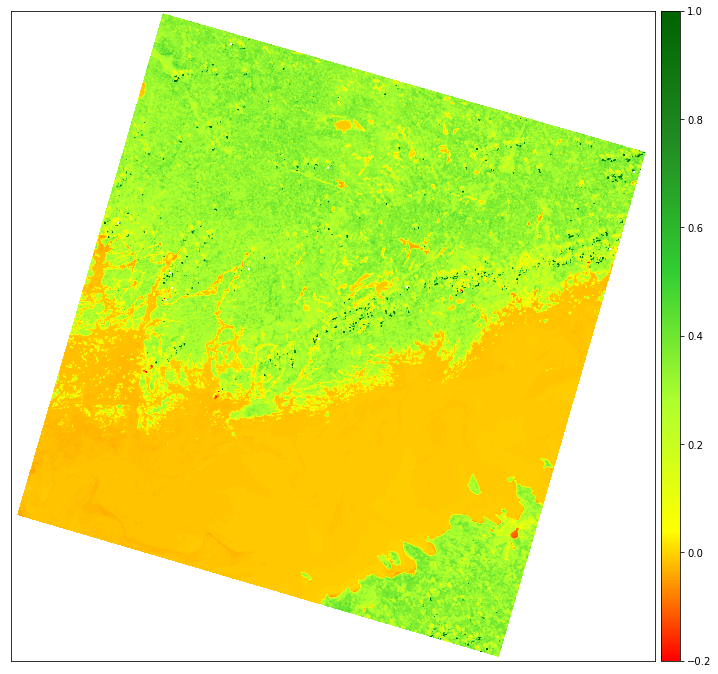

In [9]:
#visualize NDVI output




#plot ndvi
ep.plot_bands(ndvi, cmap=ndvi_cmap, cols=1, vmin=-0.2, vmax=1,scale=False)

In [10]:
#calculate fractional vegetation cover 

In [11]:
#vegprop_2=np.where(ndvi_2==-9999.0, -9999, (ndvi_2-0.2)/(0.5-0.2))

fvc = (ndvi-0.2)/(0.5-0.2)

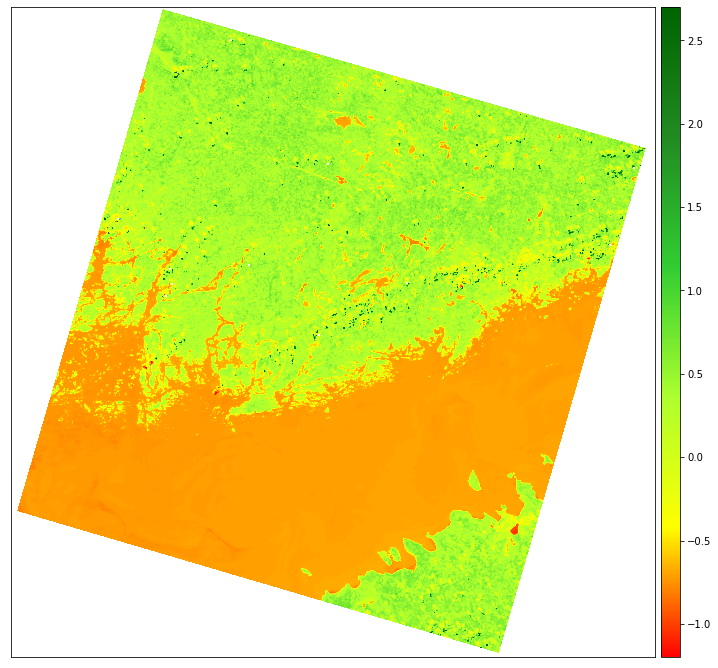

In [12]:
ep.plot_bands(fvc, cmap=ndvi_cmap, cols=1, vmin=-1.2, vmax=2.7,scale=False)

Calculte the land surface emissivity using the NDVI threshold method.

For 

NDVI ≤ 0.2 : LSEs=0.97 - bare soils (low vegetaton)

0.2 < NDVI < 0.5 : LSE =0.971·(1-fvc)+0.987·fvc  


NDVI ≥  0.5 : LSE = 0.99 - mostly (healthy) vegetation


In [13]:

emi = []

for row in range(len(ndvi)):                         #each row in the ndvi array
    
    emrow=[]                                              #emissivity of the row
    
    for i in range(len(ndvi[row])):                  #for each pixel in the row
        
        if ndvi[row][i] ==np.nan:
            emrow.append(np.nan)
            
        elif ndvi[row][i]<= 0.2:                    
            emrow.append(0.97)
            
        elif ndvi[row][i]>= 0.5:
            emrow.append(0.99)
            
        else:
            emrow.append(0.971*(1-fvc[row][i])+(0.987*fvc[row][i]))
    emi.append(emrow)
    
    
emiss = np.asarray(emi) #convert the emi to np array    

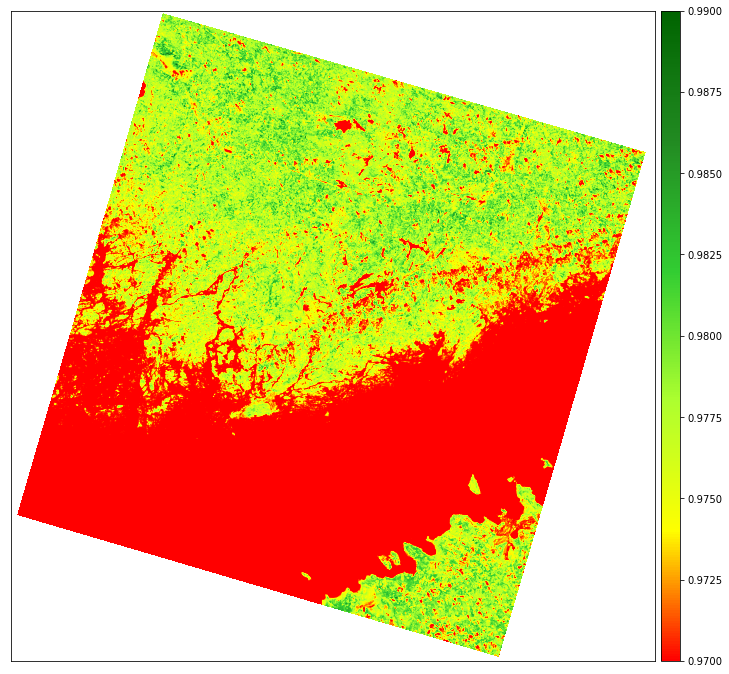

In [14]:
ep.plot_bands(emiss, cmap=ndvi_cmap, cols=1,scale=False)

In [15]:
#calculate top of the atmosphere reflectance of the thermal band

toa = (b10.astype(float)*0.0003342)+0.1 #change mult constant if not L8


In [16]:
#calculate at sensor brightness temperature and convert to degree cel

bt = (1321.0789 / np.log((774.8853 / toa) + 1)) - 273.15


#calculate delta and gamma -- parameters based on Plank's functions


delta = bt - ((bt*bt)/1324) 


gamma = (bt*bt)/(1324*toa) 



In [17]:
#calcultate atm functions 


atm_params = list()        
with open (atm_cor_params, "r") as file:
    for line in file:
        atm_params.append(line.strip()) 
atm_params

transmission = float(atm_params[0][atm_params[0].find(':')+1:].strip())

upwelling_radiance= float(atm_params[1][atm_params[1].find(':')+4:atm_params[1].find('W')-1].
                          strip())

downwelling_radiance= float(atm_params[2][atm_params[2].find(':')+2:atm_params[2].find('W')-1].
                            strip())



w1 = 1/transmission

w2 =(-1*downwelling_radiance) - (upwelling_radiance/transmission)

w3 = downwelling_radiance





print (transmission,upwelling_radiance,downwelling_radiance)

0.65 2.82 4.41


In [18]:
lst = gamma*((((1/emiss)*((w1*toa)+w2)) + w3))+delta

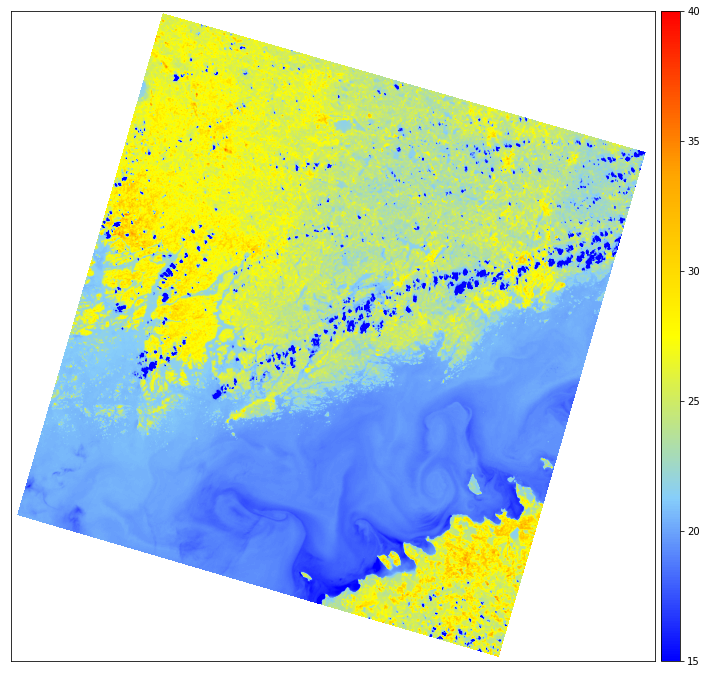

<function matplotlib.pyplot.show(*args, **kw)>

In [19]:
ep.plot_bands(lst, cmap=lst_cmap ,
              scale=False,
            vmin=15, vmax=40)
plt.show

In [20]:
grids['ndvi'] = gpd.GeoDataFrame.from_features(
                                                zonal_stats(grids,
                                                        ndvi,
                                                        stats='mean',
                                                        geojson_out=True,
                                                        affine = transfromation)
                                            )['mean'].round(2)     





grids['lst'] = gpd.GeoDataFrame.from_features(
                                                zonal_stats(grids,
                                                        lst,
                                                        stats='mean',
                                                        geojson_out=True,
                                                        affine = transfromation)
                                            )['mean'].round(2)   
    

grids = grids.to_crs('EPSG:3301')

In [21]:
grids

,GRD_INSPIR,geometry,ndvi,lst
0,1kmN6583E0537,"MULTIPOLYGON (((537000.000 6583000.000, 537000...",0.26,27.21
1,1kmN6583E0538,"MULTIPOLYGON (((538000.000 6583000.000, 538000...",0.25,27.46
2,1kmN6590E0538,"MULTIPOLYGON (((538000.000 6590439.176, 538000...",0.21,27.86
3,1kmN6587E0534,"MULTIPOLYGON (((534509.437 6588000.000, 535000...",0.10,25.24
4,1kmN6589E0535,"MULTIPOLYGON (((535000.000 6589000.000, 535000...",0.28,23.92
...,...,...,...,...
221,1kmN6591E0550,"MULTIPOLYGON (((550000.000 6591000.000, 550000...",0.32,25.79
222,1kmN6592E0550,"MULTIPOLYGON (((550000.000 6592000.000, 550000...",0.30,24.33
223,1kmN6593E0550,"MULTIPOLYGON (((550000.000 6593000.000, 550000...",0.27,24.18
224,1kmN6594E0550,"MULTIPOLYGON (((550000.000 6594000.000, 550000...",0.27,24.72


In [22]:

grids['area'] = grids.area.round(2) #calulate the area of each grid


grids['pop'] = grids.merge(pop_data,on='GRD_INSPIR')['TOTAL']


grids['pop_dens'] = (grids['pop'] /grids['area']).round(2)

In [23]:
grids.head(5)



,GRD_INSPIR,geometry,ndvi,lst,area,pop,pop_dens
0,1kmN6583E0537,"MULTIPOLYGON (((537000.000 6583000.000, 537000...",0.26,27.21,1000000.00,1798,0.0
1,1kmN6583E0538,"MULTIPOLYGON (((538000.000 6583000.000, 538000...",0.25,27.46,1000000.00,1743,0.0
2,1kmN6590E0538,"MULTIPOLYGON (((538000.000 6590439.176, 538000...",0.21,27.86,619128.60,2963,0.0
3,1kmN6587E0534,"MULTIPOLYGON (((534509.437 6588000.000, 535000...",0.10,25.24,507611.91,205,0.0
4,1kmN6589E0535,"MULTIPOLYGON (((535000.000 6589000.000, 535000...",0.28,23.92,555434.50,362,0.0


Text(0.5, 1.0, 'Population - 1Km')

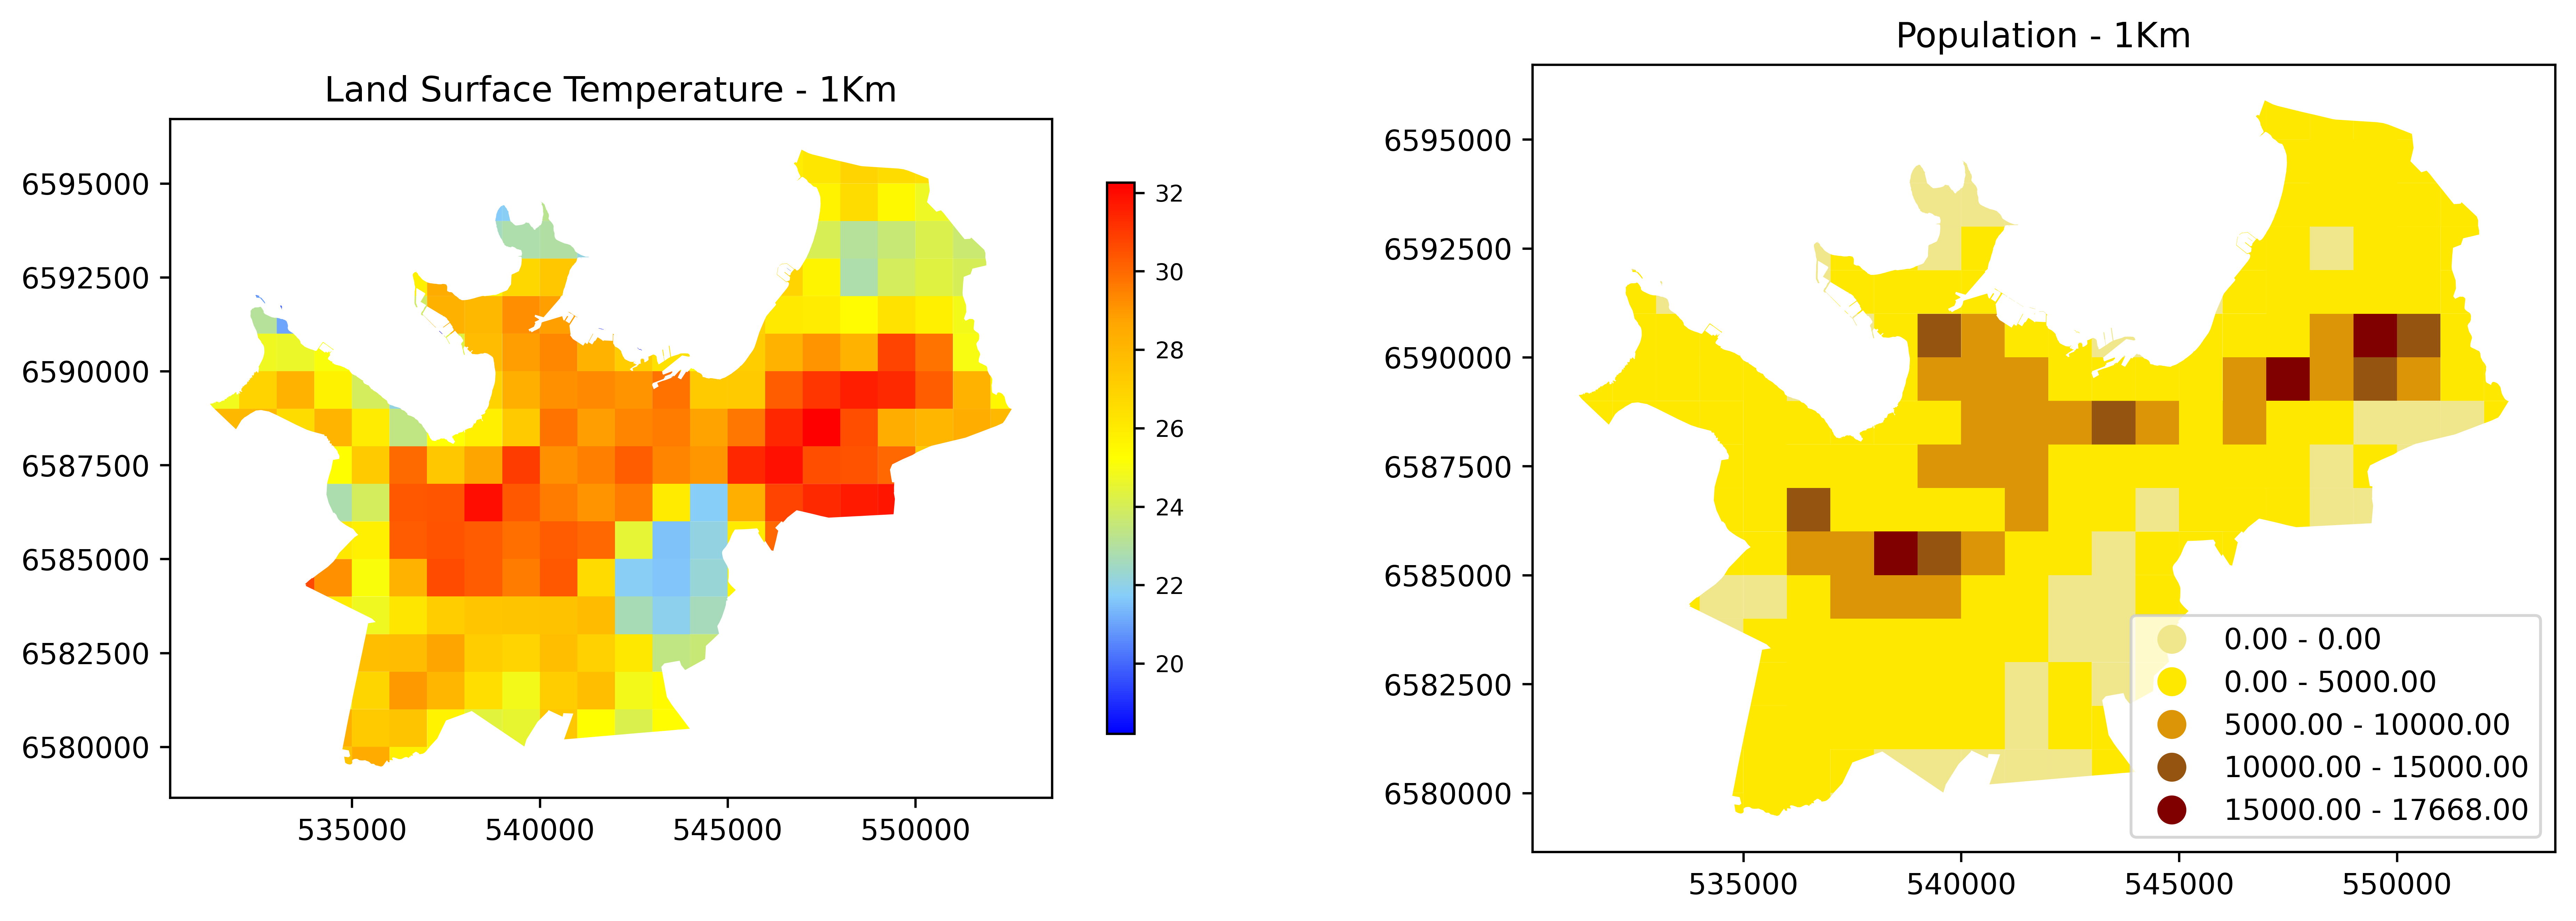

In [24]:
fig, axes = plt.subplots(1,2,figsize=(15,5),dpi=600)

ax1 , ax2 = axes.flatten()

ax1 = grids.plot(column='lst',cmap=lst_cmap,ax=ax1,legend=True,
                 legend_kwds={'shrink': 0.7})
ax1.ticklabel_format(style='plain')
ax1.figure.axes[-1].tick_params(labelsize=8)
ax1.set_title('Land Surface Temperature - 1Km')


ax2 = grids.plot(column='pop',cmap=pop_cmap ,ax=ax2,scheme='user_defined', 
                 classification_kwds={'bins':np.arange(0,18000,5000).tolist()},
                 legend=True,
                 legend_kwds={'loc': 'lower right'},
                )#legend_kwds={'shrink': 0.6}
ax2.ticklabel_format(style='plain')
ax2.figure.axes[-1].tick_params(labelsize=8)
ax2.set_title('Population - 1Km')


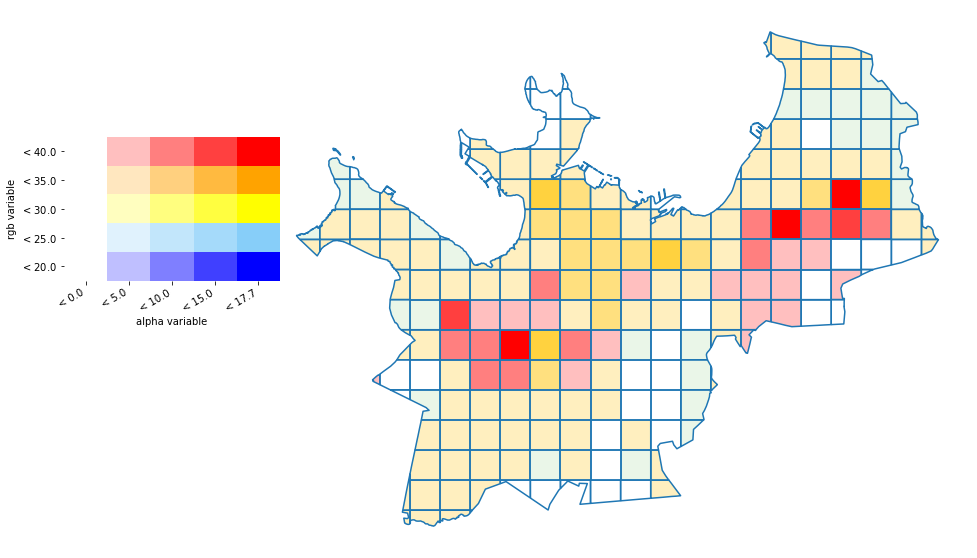

In [25]:
#Default plotting with pysal splot


x = grids['lst'].values
y = grids['pop'].values


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

grids.boundary.plot(ax=ax)
ax=vba_choropleth(x, y, grids, rgb_mapclassify=dict(classifier='user_defined',bins=[20,25,30,35,40]), cmap=lst_cmap,
                   alpha_mapclassify=dict(classifier='user_defined',bins=np.arange(0,18000,5000).tolist()),ax=ax,legend=True)



[Text(0, 0, '0'),
 Text(0, 0, '0-5000'),
 Text(0, 0, '5000-10000'),
 Text(0, 0, '10000-15000'),
 Text(0, 0, '15000-18000')]

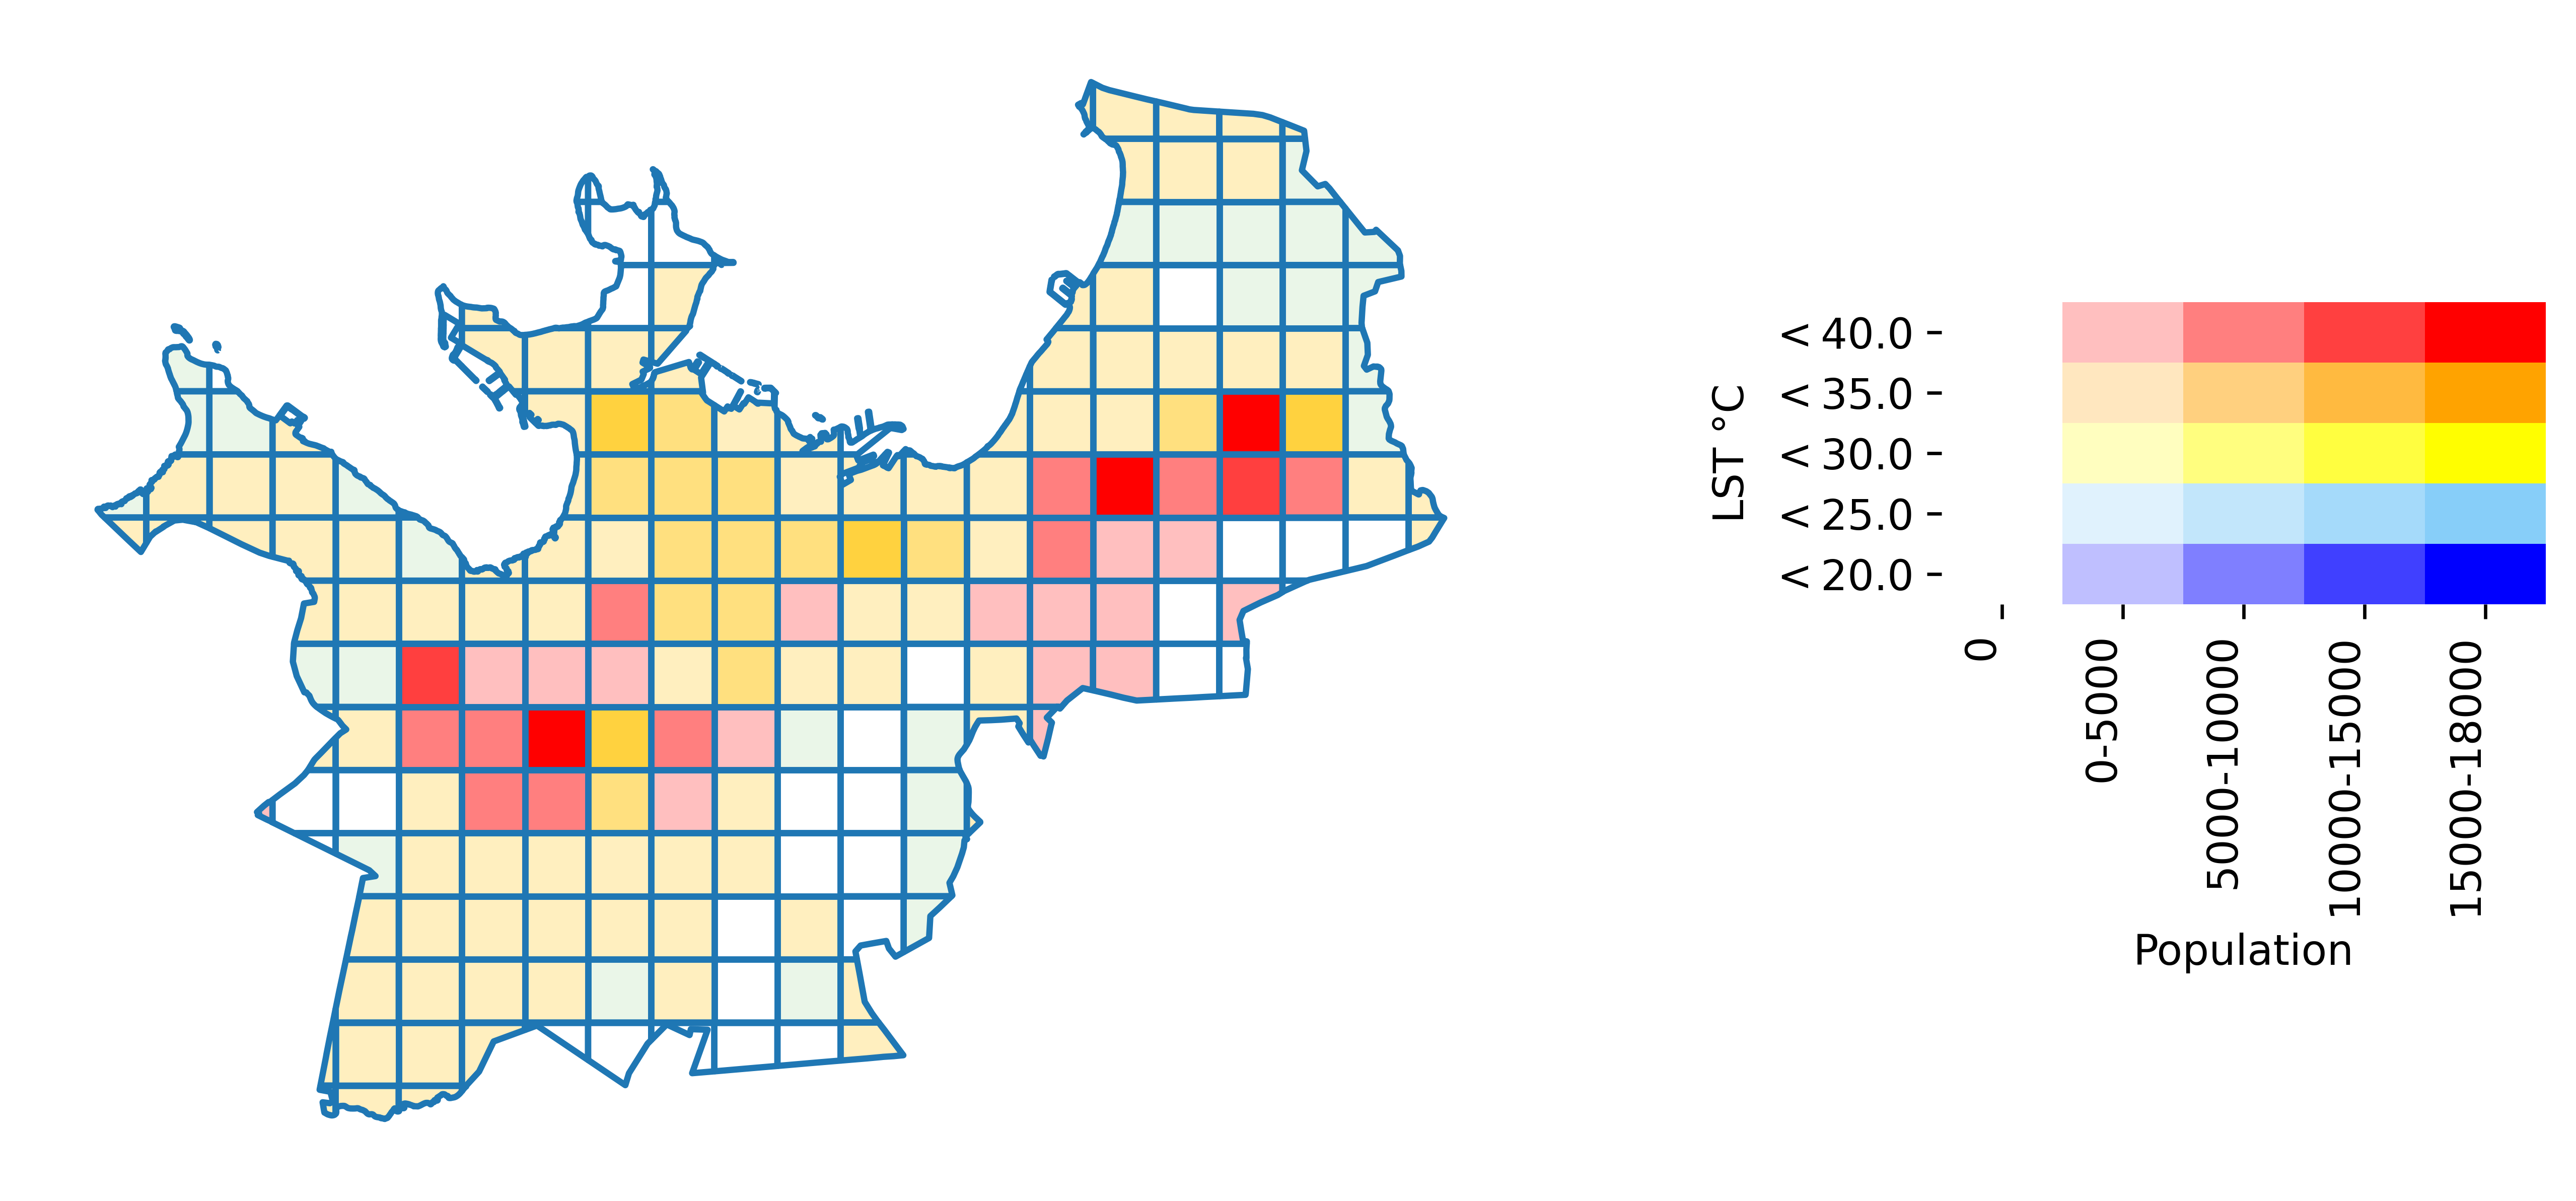

In [26]:
#custom plot with 



fig = plt.figure(dpi=600,figsize=(10,5))

ax1 = fig.add_subplot(111)

x = grids['lst'].values
y = grids['pop'].values

lst_bins = dict(classifier='user_defined',bins=[20,25,30,35,40]) #bins for the lst

pop_bins = dict(classifier='user_defined',bins=np.arange(0,18000,5000).tolist()) #bins for population
                
#plot grids and bivariate map for population and LST

grids.boundary.plot(ax=ax1)

ax1 = vba_choropleth(x, y, grids, rgb_mapclassify=lst_bins, cmap=lst_cmap,alpha_mapclassify=pop_bins,ax=ax1)




#create custom legend

rgb_bins = mapclassify_bin(x, classifier='user_defined',bins=[20,25,30,35,40]) 
alpha_bins = mapclassify_bin(y,classifier='user_defined',bins=np.arange(0,18000,5000).tolist()) #get bins for colours

left, bottom, width, height = [0.9, 0.5, 0.2, 0.2] #set position for legend within the figure 

ax2 = fig.add_axes([left, bottom, width, height]) #create axes for legend at desired position


vba_legend(rgb_bins, alpha_bins, cmap= lst_cmap, ax=ax2) #create legend

#set legend objects
ax2.set_xlabel('Population')
ax2.set_ylabel('LST °C')
ax2.set_xticklabels(['0','0-5000','5000-10000','10000-15000','15000-18000'],
                       rotation=90, horizontalalignment='right')

In [27]:

cube = make_geocube(vector_data=grids, resolution=(500, 500))
    
    
#cube.rio.to_raster('test1.tif')